# (Step 5) Model Ranking

## Using a Non-Parametric Scott-Knott ESD Test For Multiple Comparison

The Non-Parametric ScottKnott ESD (NPSK) test is a multiple comparison approach that leverages a hierarchical clustering to partition the set of median values of techniques (e.g., medians of variable importance scores, medians of model performance) into statistically distinct groups with non-negligible difference. The Non-Parametric ScottKnott ESD (NPSK) does not require the assumptions of normal distributions, homogeneous distributions, and the minimum sample size. The mechanism of the Non-Parametric Scott-Knott ESD test is made up of 2 steps:

*(Step 1) Find a partition that maximizes treatment medians between groups.* We begin by sorting the median value of the distributions. Then, we compute the Kruskal Chisq statistics to identify a partition that maximizes the median values between groups. The Kruskal Chisq test is a non-parametric test, which does not require data normality and data heterogeneity assumptions.

*(Step 2) Splitting into two groups or merging into one group.* We analyze the magnitude of the difference for each pair for all of the treatment medians of the two groups. If there is any one pair of treatment medians of two groups are non-negligible, we split into two groups. Otherwise, we merge into one group. We use the Cliff $|\delta|$ effect size to estimate the effect size of the difference between the two medians.

To illustrate how the Non-Parametric ScottKnott ESD works in practice, we first prepare a training dataset; construct defect models using 6 classification techniques (i.e., Logistic Regression, Random Forests, C5.0 (Decision Tree), Neural Network, Gradient Boosting Machine, and eXtreme Gradient Boosting Tree); and evaluate them using the AUC measure with the 10-fold cross validation approach.
We provide a code snippet below.

In [9]:
## Load Data and preparing datasets

# Import for Load Data
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np

# Import for Split Data into Training and Testing Samples
from sklearn.model_selection import train_test_split

# Import for Construct Defect Models (Classification)
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.ensemble import RandomForestClassifier # Random Forests
from sklearn.tree import DecisionTreeClassifier # C5.0 (Decision Tree)
from sklearn.neural_network import MLPClassifier # Neural Network
from sklearn.ensemble import GradientBoostingClassifier # Gradient Boosting Machine (GBM)
import xgboost as xgb # eXtreme Gradient Boosting Tree (xGBTree)

# Import for Cross-Validation
from sklearn.model_selection import cross_val_score

train_dataset = pd.read_csv(("../../datasets/lucene-2.9.0.csv"), index_col = 'File')
test_dataset = pd.read_csv(("../../datasets/lucene-3.0.0.csv"), index_col = 'File')

outcome = 'RealBug'
features = ['OWN_COMMIT', 'Added_lines', 'CountClassCoupled', 'AvgLine', 'RatioCommentToCode']

# process outcome to 0 and 1
train_dataset[outcome] = pd.Categorical(train_dataset[outcome])
train_dataset[outcome] = train_dataset[outcome].cat.codes

test_dataset[outcome] = pd.Categorical(test_dataset[outcome])
test_dataset[outcome] = test_dataset[outcome].cat.codes

X_train = train_dataset.loc[:, features]
X_test = test_dataset.loc[:, features]

y_train = train_dataset.loc[:, outcome]
y_test = test_dataset.loc[:, outcome]


# commits - # of commits that modify the file of interest
# Added lines - # of added lines of code
# Count class coupled - # of classes that interact or couple with the class of interest
# LOC - # of lines of code
# RatioCommentToCode - The ratio of lines of comments to lines of code
features = ['nCommit', 'AddedLOC', 'nCoupledClass', 'LOC', 'CommentToCodeRatio']

X_train.columns = features
X_test.columns = features
training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)


cv_kfold = 10
model_performance_df = pd.DataFrame()
## Construct defect models and generate the 10-fold Cross Validation AUC

# Logistic Regression
lr_model = LogisticRegression(random_state=1234)
model_performance_df['LR'] = cross_val_score(lr_model, X_train, y_train, cv = cv_kfold, scoring = 'roc_auc')

# Random Forests
rf_model = RandomForestClassifier(random_state=1234, n_jobs = 10)
model_performance_df['RF'] = cross_val_score(rf_model, X_train, y_train, cv = cv_kfold, scoring = 'roc_auc')

# C5.0 (Decision Tree)
dt_model = DecisionTreeClassifier(random_state=1234)
model_performance_df['DT'] = cross_val_score(dt_model, X_train, y_train, cv = cv_kfold, scoring = 'roc_auc')

# Neural Network
nn_model = MLPClassifier(random_state=1234)
model_performance_df['NN'] = cross_val_score(nn_model, X_train, y_train, cv = cv_kfold, scoring = 'roc_auc')

# Gradient Boosting Machine (GBM)
gbm_model = GradientBoostingClassifier(random_state=1234)
gbm_model.fit(X_train, y_train)  
model_performance_df['GBM'] = cross_val_score(gbm_model, X_train, y_train, cv = cv_kfold, scoring = 'roc_auc')

# eXtreme Gradient Boosting Tree (xGBTree)
xgb_model = xgb.XGBClassifier(random_state=1234)
model_performance_df['XGB'] = cross_val_score(xgb_model, X_train, y_train, cv = cv_kfold, scoring = 'roc_auc')

display(model_performance_df)
model_performance_df.plot(kind = 'box', ylim = (0, 1), ylabel = 'AUC')

/Users/jjia0028/opt/anaconda3/envs/xaitools/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/jjia0028/opt/anaconda3/envs/xaitools/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/Users/jjia0028/opt/anaconda3/envs/xaitools/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass op

[15:36:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:36:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jjia0028/opt/anaconda3/envs/xaitools/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/Users/jjia0028/opt/anaconda3/envs/xaitools/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/jjia0028/opt/anaconda3/envs/xaitools/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/

[15:36:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:36:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:36:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jjia0028/opt/anaconda3/envs/xaitools/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/jjia0028/opt/anaconda3/envs/xaitools/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/Users/jjia0028/opt/anaconda3/envs/xaitools/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass op

[15:36:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:36:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jjia0028/opt/anaconda3/envs/xaitools/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/Users/jjia0028/opt/anaconda3/envs/xaitools/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/jjia0028/opt/anaconda3/envs/xaitools/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/

[15:36:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:36:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jjia0028/opt/anaconda3/envs/xaitools/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/Users/jjia0028/opt/anaconda3/envs/xaitools/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/jjia0028/opt/anaconda3/envs/xaitools/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/

[15:36:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jjia0028/opt/anaconda3/envs/xaitools/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


,LR,RF,DT,NN,GBM,XGB
0,0.805701,0.575852,0.488532,0.746396,0.661042,0.566186
1,0.830603,0.817824,0.578145,0.677261,0.861402,0.753277
2,0.848296,0.797837,0.596003,0.859764,0.800131,0.776212
3,0.677778,0.710943,0.617677,0.594949,0.699327,0.728283
4,0.856902,0.864983,0.672222,0.619529,0.895960,0.817508
5,0.732323,0.761953,0.510774,0.622559,0.784848,0.711785
6,0.724916,0.809091,0.525253,0.772391,0.794949,0.745455
7,0.712795,0.628620,0.511111,0.622559,0.606902,0.605051
8,0.878016,0.752973,0.569317,0.868841,0.741930,0.629630
9,0.646619,0.614849,0.534149,0.671424,0.635406,0.603126


<AxesSubplot:ylabel='AUC'>

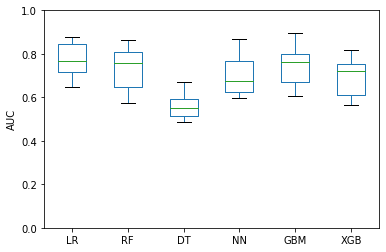

In [22]:
display(model_performance_df)
model_performance_df.to_csv('model_performance.csv')
model_performance_df.plot(kind = 'box', ylim = (0, 1), ylabel = 'AUC')

*Please note that we neither pre-process data nor optimise the hyper-parameter settings of models in this tutorial. Therefore, the generated performance estimates may be altered if the data is well processed and the hyper-parameter settings are appropriately optimised.*

Then, we apply the Non-Parametric ScottKnott ESD approach to the performance estimates of the 6 classification techniques. We use the implementation as provided by the [ScottKnottESD](https://github.com/klainfo/ScottKnottESD) R package.

```{admonition} R code
:class: tip
library(ScottKnottESD)

sk_results <- sk_esd(model_performance_df)

plot(sk_results)
```



```{figure} /defect-prediction/images/scottknott_esd.png
---
name: scottknott_ranking
---
A visualisation of model performance ranking according to the Non-Parametric ScottKnott ESD approach.
```

{numref}`scottknott_ranking` illustrates a visualisation of model performance ranking according to the Non-Parametric ScottKnott ESD approach.
According to {numref}`scottknott_ranking`, we find that Logistic Regression appears as the 1st rank; Gradient Boosting Machine and Random Forests appear as the 2nd rank; Neural Network and eXtreme Gradient Boosting Tree appear as the 3rd rank; and, finally, Decision Tree appears as the 4th rank.

```{note}
Parts of this chapter have been published by Chakkrit Tantithamthavorn, Shane McIntosh, Ahmed E. Hassan, Kenichi Matsumoto:
An Empirical Comparison of Model Validation Techniques for Defect Prediction Models. IEEE Trans. Software Eng. 43(1): 1-18 (2017).
```

## Suggested Readings

[1] Chakkrit Tantithamthavorn, Shane McIntosh, Ahmed E. Hassan, Kenichi Matsumoto:
An Empirical Comparison of Model Validation Techniques for Defect Prediction Models. IEEE Trans. Software Eng. 43(1): 1-18 (2017)


[2] Chakkrit Tantithamthavorn, Shane McIntosh, Ahmed E. Hassan, Kenichi Matsumoto:
The Impact of Automated Parameter Optimization on Defect Prediction Models. IEEE Trans. Software Eng. 45(7): 683-711 (2019)
